In [1]:
%cd ../../..

/home/pristalovya/Inter/Programming/nlp-coursework


In [27]:
from src.nlp.application import (Pipeline, 
                                 get_df_by_film_and_person, 
                                 get_df_by_person, 
                                 collect_sents_to_summarize,
                                 split_opinions_to_chunks)
from datasets_ import DatasetLoader

import dill
from tqdm.notebook import tqdm
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib notebook
from wordcloud import WordCloud


from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline
from transformers import MBartTokenizer, MBartForConditionalGeneration
from transformers import AutoTokenizer, T5ForConditionalGeneration
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers.pipelines.question_answering import QuestionAnsweringPipeline


import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
data = DatasetLoader.load_named_entities_dataset(show_path=True)
data

/home/pristalovya/Inter/Programming/nlp-coursework/data/named_entities.csv


,ne,occurrences,film_id,n_sents
0,Кинг,[Несколько лет назад прочитала оригинальный ро...,435,150
1,Дарабонт,[После взросления и прочтения книги фильм Дара...,435,65
2,Перси,[Особенно нелепа вся эта линия с травлей Перси...,435,93
3,Депрессия,"[За то, что работает по блату (во времена Депр...",435,1
4,Делакруа,"[И кстати, ради большей слезовыжималки сценари...",435,26
...,...,...,...,...
106669,Сергей Эйзенштейн,[В качестве наглядного примера могу предложить...,969760,1
106670,Ферруччо,[Молодой Ферруччо - типичный англо-саксонский ...,969760,9
106671,Эдуардо де Филиппо,[Авторам смотреть старые итальянские фильмы и ...,969760,1
106672,Ютюба,[И он по законам мотивашек с Ютюба читает как ...,969760,1


In [ ]:
# tokenizer = AutoTokenizer.from_pretrained("AlexKay/xlm-roberta-large-qa-multilingual-finedtuned-ru")
# model = AutoModelForQuestionAnswering.from_pretrained("AlexKay/xlm-roberta-large-qa-multilingual-finedtuned-ru")

In [6]:
# listed_opinions = collect_sents_to_summarize(get_df_by_person(data, 'хэнкс'), n_sents = 100)
# opinions = '\n'.join(listed_opinions)

In [4]:
# a) Get predictions
model_name = "AlexKay/xlm-roberta-large-qa-multilingual-finedtuned-ru"
model = pipeline('question-answering', model=model_name, tokenizer=model_name, device=device)

In [16]:
def get_person_characteristics(data: pd.DataFrame, 
                               name: str, 
                               model: QuestionAnsweringPipeline,
                               film_id: int = None,
                               ):
    from src.nlp.preprocessing import clean
    from random import shuffle
    
    _N_SENTS = 100
    
    if film_id is not None:
        listed_opinions = collect_sents_to_summarize(
            get_df_by_film_and_person(data, film_id, name), 
            n_sents = _N_SENTS
        )
    else:
        listed_opinions = collect_sents_to_summarize(
            get_df_by_person(data, name), 
            n_sents = _N_SENTS
        )       
    
    opinions = '\n'.join(listed_opinions)
#     print(opinions, end='\n------------------------------------\n')
    opinions = clean(opinions, char_clean_only=True, lowercase=False)
#     print(opinions)
    
    answers = []
    scores = []

    try:
        while True:
            QA_which_input = {
                'question': f'Какая {name}?',
                'context': opinions
            }
            answer = model(QA_which_input)
            print(answer, end='\n\n')
            opinions = opinions.replace(answer['answer'], ' ')
            answers.append(answer['answer'])
            scores.append(answer['score'])

            QA_do_input = {
                'question': f'Что сделала {name}?',
                'context': opinions
            }
            answer = model(QA_do_input)
            print(answer, end='\n\n')
            opinions = opinions.replace(answer['answer'], ' ')
            answers.append(answer['answer'])
            scores.append(answer['score'])
    except KeyboardInterrupt:
        pass
    finally:
        return scores, answers
        
        

In [17]:
scores, answers = get_person_characteristics(data, 'Хэтэуэй', model)

{'score': 0.6866518259048462, 'start': 5516, 'end': 5536, 'answer': ' прекрасная актриса,'}

{'score': 0.5645515322685242, 'start': 6473, 'end': 6508, 'answer': ' отлично отыграла своего персонажа,'}

{'score': 0.3694393038749695, 'start': 11617, 'end': 11652, 'answer': ' свежа, очаровательна и убедительна'}

{'score': 0.3420686721801758, 'start': 12963, 'end': 12983, 'answer': ' стала Селиной Кайл.'}

{'score': 0.4906225800514221, 'start': 12358, 'end': 12378, 'answer': ' Потрясающая, милая,'}

{'score': 0.3423472046852112, 'start': 16342, 'end': 16356, 'answer': ' делает выбор,'}

{'score': 0.3278907835483551, 'start': 8010, 'end': 8039, 'answer': ' невероятно красивая женщина.'}

{'score': 0.2848639190196991, 'start': 6804, 'end': 6818, 'answer': ' Неплохую игру'}



In [18]:
scores

[0.6866518259048462,
 0.5645515322685242,
 0.3694393038749695,
 0.3420686721801758,
 0.4906225800514221,
 0.3423472046852112,
 0.3278907835483551,
 0.2848639190196991]

In [19]:
answers

[' прекрасная актриса,',
 ' отлично отыграла своего персонажа,',
 ' свежа, очаровательна и убедительна',
 ' стала Селиной Кайл.',
 ' Потрясающая, милая,',
 ' делает выбор,',
 ' невероятно красивая женщина.',
 ' Неплохую игру']

In [29]:
clean_answers = list(map(lambda s: s.strip(' .,:'), answers))

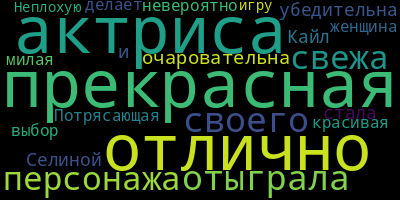

In [30]:
wc = WordCloud().generate(' '.join(clean_answers))
wc.to_image()

In [5]:
listed_opinions = collect_sents_to_summarize(get_df_by_person(data, 'хэтэуэй'), n_sents = 100)
opinions = '\n'.join(listed_opinions)

answers = []

while True:
    QA_input = {
        'question': 'Что сделала Хэтэуэй?',
        'context': opinions}
    answer = nlp(QA_input)
    print(answer, end='\n\n')
    opinions = opinions.replace(answer['answer'], ' ')
    answers.append(answer['answer'])

{'score': 0.5166663527488708, 'start': 9153, 'end': 9173, 'answer': ' стала Селиной Кайл.'}

{'score': 0.44638943672180176, 'start': 13962, 'end': 13998, 'answer': ' мастерски воплотила Энди на экране,'}

{'score': 0.3692881464958191, 'start': 927, 'end': 965, 'answer': " отлично сыграла 'блаженную' королеву,"}

{'score': 0.4662542939186096, 'start': 15934, 'end': 15948, 'answer': ' делает выбор,'}

{'score': 0.27789342403411865, 'start': 7304, 'end': 7335, 'answer': ' отлично выполнила свою работу.'}

{'score': 0.27670738101005554, 'start': 14036, 'end': 14066, 'answer': ' своим упорством и трудолюбием'}

{'score': 0.26221901178359985, 'start': 8339, 'end': 8382, 'answer': ' вполне достойно справилась со своей ролью.'}

{'score': 0.30214592814445496, 'start': 9017, 'end': 9039, 'answer': ' замечательно сыграла,'}

{'score': 0.29231899976730347, 'start': 15927, 'end': 15955, 'answer': ' сыграла она просто блестяще'}

{'score': 0.275224894285202, 'start': 14325, 'end': 14364, 'answer': 


KeyboardInterrupt



In [13]:
answers_str = '\n'.join(answers)

In [15]:
print(answers_str)

 невероятно красивая женщина.
 своенравная, дерзкая, гордая и опасная,
 красивая, сексуальная и убедительная
 Красавица

Героиня
 невероятна:
 милая Энн была на высоте,
 взрослеющую звезду,
 по плечу все роли.
 талантливой актрисой,
 роль на самом деле небольшая.
 готичной королевы.
 моя любимая актриса,

Женщину — кошку
 'блаженную' королеву,
 прекрасная актриса,
 милая, обаятельная и мечтательная Белая Королева..
 покорительницы космической бездны.
 чертовски хороша,

Хороша
 свежа, очаровательна и убедительна
 грациозная, гибкая, неприступная,
 Потрясающая, милая,
 героиня жаждущая любить и быть любимой,
 бесподобна,
 стервозной, грациозной и сексуальной женщины-кошки
 маленькую,
 прекрасную
 очень хороша.
 отлично играющую без скидок на возраст,
 обычной обаятельной девушки,
 единственная женщина, которая получила двоякую роль,
 очаровательная и милая
 очаровательной
 потрясающая
 была великолепна,
 права,
 Энди Сакс
 это идеальное сочетание качеств
 романтичных, мечтательных и оба

#### Summarization by mBART

In [13]:
model_name = "IlyaGusev/mbart_ru_sum_gazeta"
tokenizer = MBartTokenizer.from_pretrained(model_name)
model = MBartForConditionalGeneration.from_pretrained(model_name)

In [20]:
input_ids = tokenizer(
    [answers],
    max_length=600,
    padding="max_length",
    truncation=True,
    return_tensors="pt",
)["input_ids"]

output_ids = model.generate(
    input_ids=input_ids,
    no_repeat_ngram_size=4,
    min_length = 500,
    max_new_tokens=1000
)[0]

summary = tokenizer.decode(output_ids, skip_special_tokens=True)
print(summary, end='\n\n')


В российском прокате «Эн Хэтэуэй: Женщина-кошка» — одна из самых интересных и красивых актрис Голливуда, сыгравшая Белую Королеву в космической бездне, а также сыгравшая Энди Сакс в мраморном замке в исполнении Андреа Андреа Нолана, которая сыграла героиню-кошку в фильме «Таинственный лес» и стала одной из самых популярных актрис в российском кино с момента выхода картины на экраны в 2011 году.. В этом году она сыграла главную роль в сериале «Энн: Белая Королева» — в главной роли в ленте «Секс-таинственный замок» в исполнении Энди Скотта Скотта Нолана в роли Белой Королевы в космического принцессии. В роляхозревателя космической королевы-ко-кошки-кошки Энновой-короевы-кошки, которую она играла в Голливудской космической женщины-кошек-кошки в «блаженной Королевы-королевки-кошки» в Голливуданы-кошеккишницы-кошки и «блаженщины-кошки «блаженки-кошка-кошки», — Белой Королевской королевы-короевой-кошки.» и «кошки-королевской королевы» в роляхрупкой-кошки — «блаженской королевышки-кошикшной к

#### Summarization by FRED-T5

In [12]:
tokenizer = AutoTokenizer.from_pretrained("ai-forever/FRED-T5-large")
model = AutoModelForSeq2SeqLM.from_pretrained("ai-forever/FRED-T5-large")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


...to be continued...